In [11]:
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arasekin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\arasekin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df= pd.read_csv('archive/Ling.csv')

In [3]:
df.head()

,subject,body,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [4]:
df = df.drop('subject', axis=1)

In [5]:
df.isnull().sum()

body     0
label    0
dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['body'], df['label'], test_size=0.2, random_state=42)

In [7]:
X_train

1902    we placed an ad in one small area of the inter...
2019    this query is addressed to all those linguists...
651     do n't want to receive these e-mails ? click t...
2284    new research position salk institute for biolo...
1322    scil-10 june 6 & 7 northwestern university ann...
                              ...                        
1638    workshop on language resources for european mi...
1095    while proofreading a translation of a text int...
1130    hello my name is wayne , if you are like me , ...
1294    conference organizer : faculty of foreign lang...
860     call for papers special conference on johann l...
Name: body, Length: 2287, dtype: object

In [8]:
def text_preprocess(ds: pd.Series) -> pd.Series:
    ds = ds.str.lower()
    ds = ds.str.replace(r'[^a-zA-Z\s]+', '', regex=True)
    ds = ds.str.split()
    ds = ds.apply(lambda x: [word for word in x if word not in stopwords.words('english')])
    lemmatizer = WordNetLemmatizer()
    ds = ds.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    ds = ds.str.join(' ')
    return ds

X_train = text_preprocess(X_train)


In [9]:
X_train

1902    placed ad one small area internet dust started...
2019    query addressed linguist speak dialect aw ay r...
651     nt want receive email click following link rem...
2284    new research position salk institute biologica...
1322    scil june northwestern university annenberg ha...
                              ...                        
1638    workshop language resource european minority l...
1095    proofreading translation text english found re...
1130    hello name wayne like probably needing earn ex...
1294    conference organizer faculty foreign language ...
860     call paper special conference johann leo weisg...
Name: body, Length: 2287, dtype: object

In [10]:
X_test = text_preprocess(X_test)

In [12]:
# Fit the TF-IDF vectorizer on the training data only
tfidf_vectorizer = TfidfVectorizer(max_features=100, 
                                   #ngram_range=(1, 2)
                                   )
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the already fitted vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

tfidf_vectorizer.get_feature_names_out()

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(2287, 100)
(572, 100)


In [13]:
# Train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       496
           1       0.95      0.93      0.94        76

    accuracy                           0.98       572
   macro avg       0.97      0.96      0.97       572
weighted avg       0.98      0.98      0.98       572



In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = model.predict(X_test_tfidf)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       496
           1       0.99      0.92      0.95        76

    accuracy                           0.99       572
   macro avg       0.99      0.96      0.97       572
weighted avg       0.99      0.99      0.99       572



In [15]:

# Feature Importance
feature_importance = model.feature_importances_
feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

# Sort features by importance
sorted_idx = np.argsort(feature_importance)
sorted_features = feature_names[sorted_idx]
sorted_importance = feature_importance[sorted_idx]

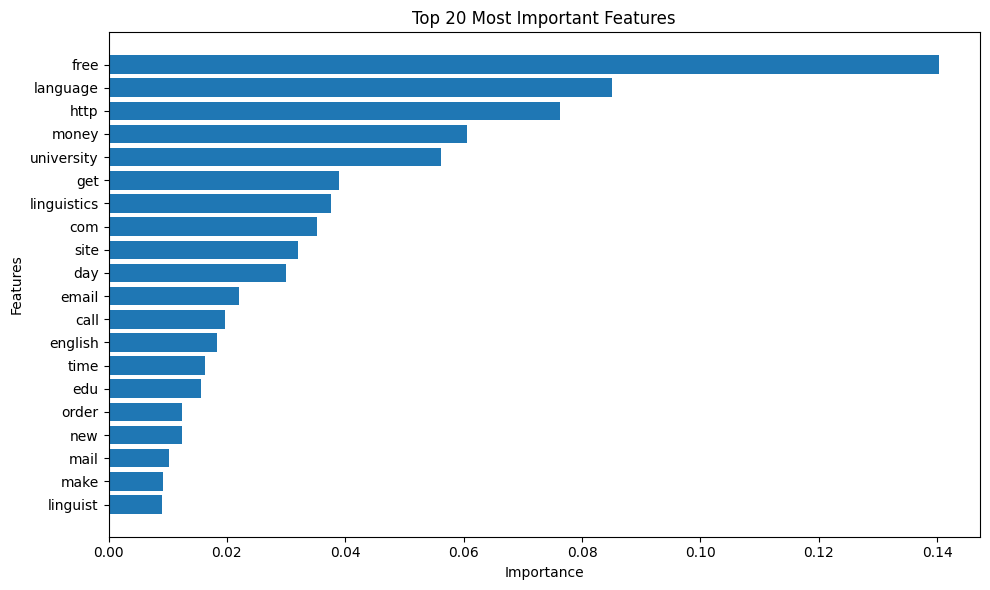

free: 0.1402
language: 0.0851
http: 0.0763
money: 0.0605
university: 0.0562
get: 0.0389
linguistics: 0.0376
com: 0.0353
site: 0.0320
day: 0.0300
email: 0.0221
call: 0.0196
english: 0.0184
time: 0.0163
edu: 0.0157
order: 0.0124
new: 0.0124
mail: 0.0102
make: 0.0092
linguist: 0.0091


In [17]:
plt.figure(figsize=(10, 6))
plt.barh(range(20), sorted_importance[-20:])
plt.yticks(range(20), sorted_features[-20:])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

# Print top 20 most important features
top_20_features = list(zip(sorted_features[-20:], sorted_importance[-20:]))
for feature, importance in reversed(top_20_features):
    print(f"{feature}: {importance:.4f}")

# Save feature importance to a CSV file
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)
feature_importance_df.to_csv('feature_importance.csv', index=False)